In [1]:
import numpy as np
import cvxpy as cp
from Localization import substitution_multi_lateration
from matplotlib import pyplot as plt
import labellines as ll

# Manually choose $x_0\sim x_T$

In [2]:
T = 9
x = np.array([[0,0],[0,1],[1,1],[2,1],[2,2],[2,3],[3,3],[4,3],[4,4]])

## Calculate $r_{ij}$ matrix

In [3]:
R=np.linalg.norm(x[:,np.newaxis,:]-x,axis=-1)
R+=np.random.randn(*R.shape)*0.01 # Add some random noise
R*=np.ones(R.shape)-np.eye(len(R)) # Remove the noise on the diagonal axis

In [4]:
print(R)

[[-0.          0.99985208  1.4100901   2.23313738  2.80959929  3.5921858
   4.23852157  5.01081721  5.64545954]
 [ 1.00904754  0.          0.99356556  1.99653306  2.23315517  2.82827823
   3.60339362  4.48117501  4.99625278]
 [ 1.41304165  0.98567519 -0.          0.97764082  1.39423268  2.22334134
   2.83161467  3.60195487  4.25687643]
 [ 2.24268835  1.99764166  0.98926737  0.          0.9920129   2.00771351
   2.23637182  2.83264622  3.5964507 ]
 [ 2.84180225  2.24161114  1.40081831  1.00297821 -0.          0.9985656
   1.41305161  2.24435134  2.83838099]
 [ 3.60099496  2.82163409  2.24425461  2.00110017  1.00618726  0.
   0.99439001  2.00425981  2.23878892]
 [ 4.23399865  3.59878316  2.82721045  2.2340883   1.416567    0.99250978
   0.          1.00927679  1.40251898]
 [ 4.99483587  4.46029646  3.60749653  2.83330214  2.23233522  2.00789585
   1.00192768  0.          0.98230538]
 [ 5.64706177  4.99852346  4.23633262  3.60652111  2.83520371  2.23398489
   1.4196006   0.99997867 -0.   

## Define the anchor points(known locations)

In [5]:
# The achor points: x_0 and x_1, are assumed to be known.
anchor_indices = [0,1,2]

anchors = x[anchor_indices,:]

unknown_index = range(3,9)

## Give initial guess using the naive subsitution-based algorithm

In [6]:
init_guess = np.array([substitution_multi_lateration(anchors,R[anchor_indices,u]) for u in unknown_index])

## Iterative solver for the stationary point of the following problem

$$
        \min_{x_{T+1},...,x_{T+N}} \sum_{i=1}^T\sum_{j=1}^N \sigma^{-2}_{i,T+j}(||x_i-x_{T+j}||-r_{i,T+j})^2 + \sum_{i,j=1}^N \sigma^{-2}_{T+i,T_j}(||x_{T+i}-x_{T+j}||-r_{T+i,T+j})^2
$$

Where $x_{1:T}$ are the known anchor locations, and $x_{T+1:T+N}$ are the unknown locations to be determined. $\sigma_{ij}$ are weights characterizing the importance of a particular distance measurement $r_{ij}$, with large $\sigma_{ij}$ corresponds to readings with large uncertainty, and therefore the terms is assigned less importance in optimization.


I will try out two schemes of $\sigma_{ij}$ settings to see which one looks better. The first is $\sigma_{ij}=1$ for all $i,j$, the second is $\sigma_{ij}=r_{ij}$.

The stationarity condition for a particular $x_i$ with $i\geq T+1$ that we use is

$$
        x_i = F_i(\mathbf{x}):= \frac{\sum_{j\in [T+N]/\{i\}}\bigg( (\sigma_{ij}^{-2}+\sigma_{ji}^{-2})x_j+\frac{\sigma_{ij}^{-2}r_{ij}+\sigma_{ji}^{-2}r_{ji}}{||x_i-x_j||}(x_i-x_j)\bigg)}{\sum_{j\in [T+N]/\{i\}} (\sigma^{-2}_{ij}+\sigma^{-2}_{ji})}
$$

Where $\mathbf{x}=x_{T+1:T+N}$. Note that the unknown locations also show up in the RHS as well.

We will implement an iterative algorithm to solve for $\mathbf{x}$ that satisfies the equations above for all $i=T+1,...,T+N$. Let $\mathbf{x}_{t}$ be the $t$'th iterative of the algorithm, and it is updated according to
$$
    \mathbf{x}_{t+1} \gets F(\mathbf{x}_t):=[F_{T+1}(\mathbf{x}_t),F_{T+2}(\mathbf{x}_t),...,F_{T+N}(\mathbf{x}_t)]^{\top} 
$$

with

$$
    \mathbf{x}_0=\text{ Initial guess provided by the substitution-based algorithm above. }
$$

and terminates when 

$$
    ||\mathbf{x}_{t+1}-\mathbf{x}_t||<\epsilon
$$

for some pre-set small $\epsilon>0$.


In [7]:
x_est = init_guess

In [8]:
def iterative_multi_lateration(anchors,initial_guess,R,\
                                epsilon = 0.001,\
                                max_iter = 100):

    '''
        anchors: shape = (T,space_dim). The list of known locations.
        initial_guess: shape = (N,space_dim). The initial guess of unknown locations,
        R: The distance reading matrices. 

        The input format of R(important): Let X = vstack([anchors,initial_guess]), then R should satisfy R_ij = ||X_i-X_j||.

        Output: x_est. shape = initial_guess.shape
    '''

    T = len(anchors)
    N = len(initial_guess)

    assert(len(R)==T+N)


    lack = np.ones((T+N,T+N))-np.eye(T+N)

    # Different schemes of weight matrix M.
    # M = np.ones((T,T))# M = [\sigma_{ij}^{-2}]_ij
    M = 1/((R+np.eye(T+N))**2)

    M*=lack


    MM = M+M.T
    MM*=lack
    M*=lack
    x_est =  init_guess 
    X = np.vstack([anchors,x_est])

    # The slow, for-loop implementation of iterative update
    # x_est_2=[]
    # for i in range(3,T):
    #     x_i_est = np.sum([(M[i,j]+M[j,i])*X[j,:]+\
    #                      (M[i,j]*R[i,j]+M[j,i]*R[j,i])*(X[i,:]-X[j,:])/np.linalg.norm(X[i,:]-X[j,:])\
    #                       for j in range(T) if not j==i],axis=0)\
    #                 /np.sum([M[i,j]+M[j,i] for j in range(T) if not j==i])
    #     x_est_2.append(x_i_est)

    # x_est_2 = np.array(x_est_2)

    # The vectorized implementation of iterative update

    x_est =  init_guess 

    for _ in range(max_iter):
        X = np.vstack([anchors,x_est])
        D = np.linalg.norm(X[:,np.newaxis,:]-X,axis=-1)# D = [||x_i-x_j||]_ij
        D+=np.eye(len(D))
        MDR = (M*R+(M*R).T)/D

        X=(MM.dot(X)+MDR.dot(np.ones(len(MDR))).reshape(-1,1)*X-MDR.dot(X))/np.sum(MM,axis=1).reshape(-1,1)

        new_est = X[len(anchors):]
        diff = np.linalg.norm(x_est-new_est)

        x_est = new_est
        if diff<epsilon:
            break
            
    # Sanity check
    # print(x_est-x_est_2) 
    

    return x_est

    

In [10]:
x_est = iterative_multi_lateration(anchors,init_guess,R)

## Visualize

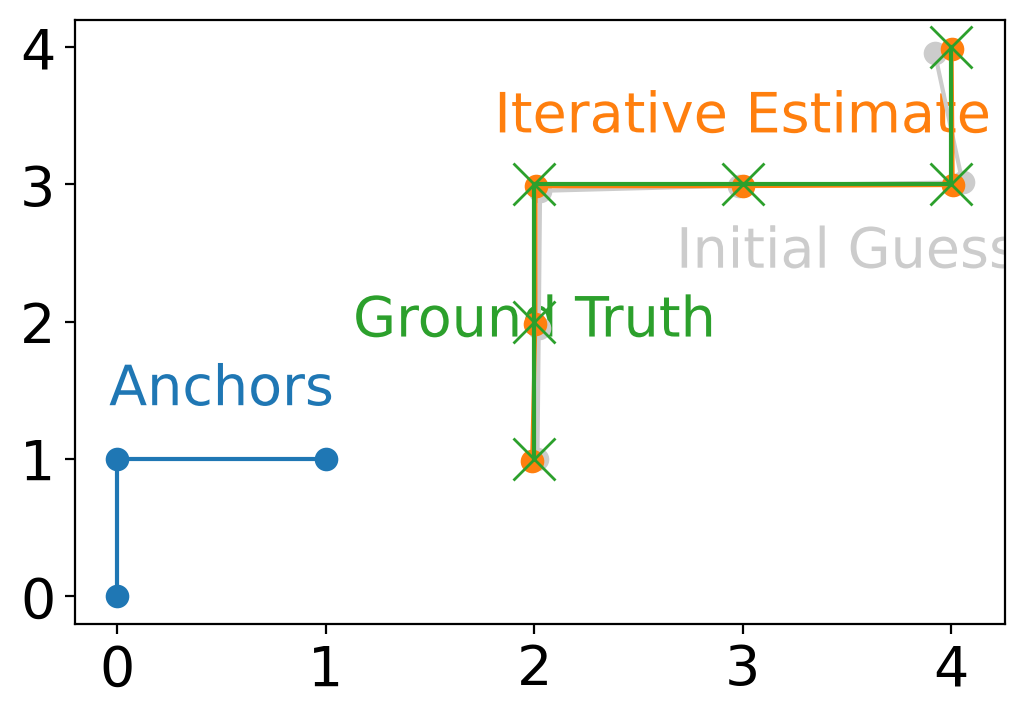

In [12]:
plt.rc('font',size=20)

plt.figure(dpi=200)

plt.plot(x[:3,0],x[0:3,1],marker = '.',markersize = 15,label='Anchors')

plt.plot(init_guess[:,0],init_guess[:,1],marker = '.',markersize = 15,label='Initial Guess',color='0.8')
plt.plot(x_est[:,0],x_est[:,1],marker = '.',markersize = 15,label='Iterative Estimate')
plt.plot(x[3:,0],x[3:,1],marker = 'x',markersize = 15,label='Ground Truth')


# ll.labelLines(plt.gca().get_lines(),fontsize=20,zorder=3,yoffsets=0.2,align=False)

lines = plt.gca().get_lines()


ll.labelLine(lines[0],0.5,fontsize=20,zorder=3,yoffset=0.5)

ll.labelLine(lines[1],3.5,fontsize=20,zorder=-3,yoffset=-0.5,align=False)

ll.labelLine(lines[2],3,fontsize=20,zorder=-3,yoffset=0.5,align=False)


ll.labelLine(lines[3],2,fontsize=20,zorder=-3,yoffset=0.5,align=False)


plt.show()